In [3]:
import numpy as np
import matplotlib.pyplot as plt

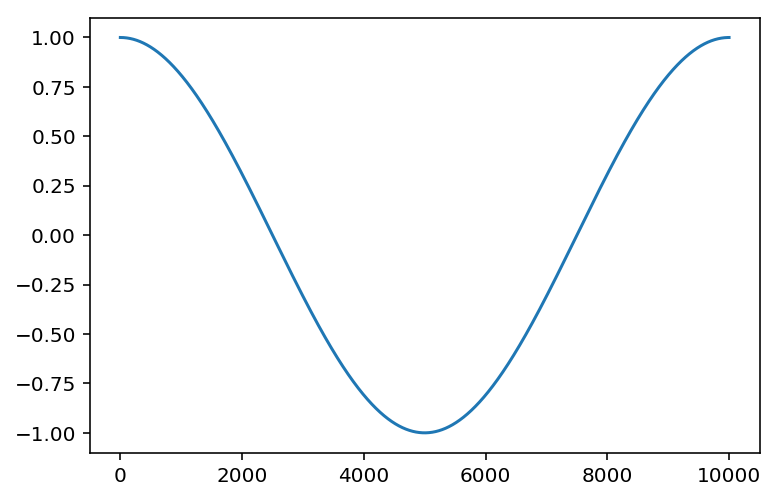

In [33]:
n = 10000
x = np.linspace(0, 2*np.pi, n)
y = np.cos(x)
plt.plot(y)
plt.show()

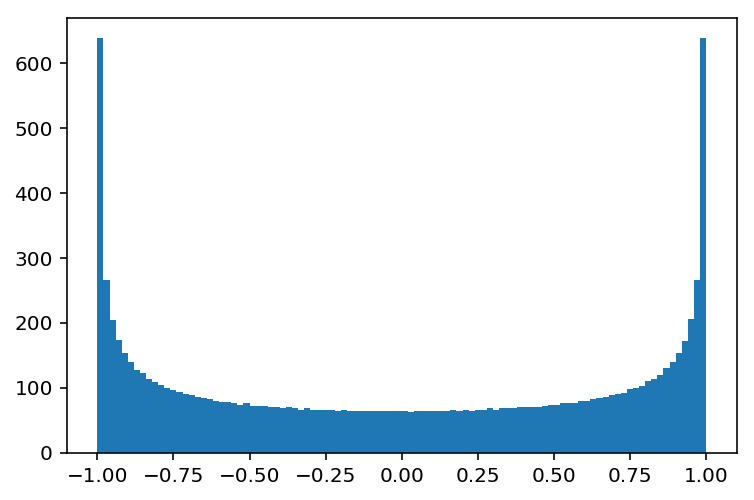

In [34]:
plt.hist(y, bins=100)
plt.show()

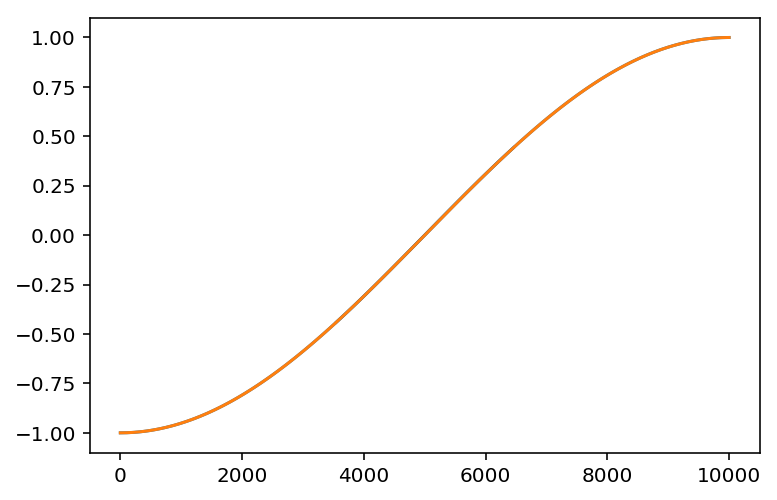

In [37]:
plt.plot(sorted(y))
plt.plot(-np.cos(np.linspace(0, np.pi, n)))
plt.show()

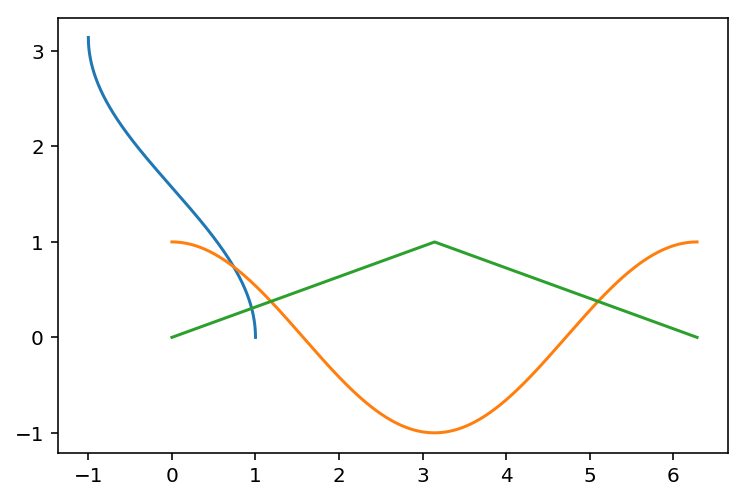

In [47]:
xi = np.linspace(-1, +1, n)
yi = np.arccos(xi)
plt.plot(xi, yi)
plt.plot(x, y)
plt.plot(x, np.arccos(y) / np.pi)
plt.show()

In [51]:
# input: 0 to 2pi real
# output: 0 to n-1 int
def pack_angle(x, n):
    out = np.arccos(x) * ((n - 1) / np.pi)
    return np.round(out)

def unpack_angle(x, n):
    return np.cos(x * (np.pi / (n - 1)))

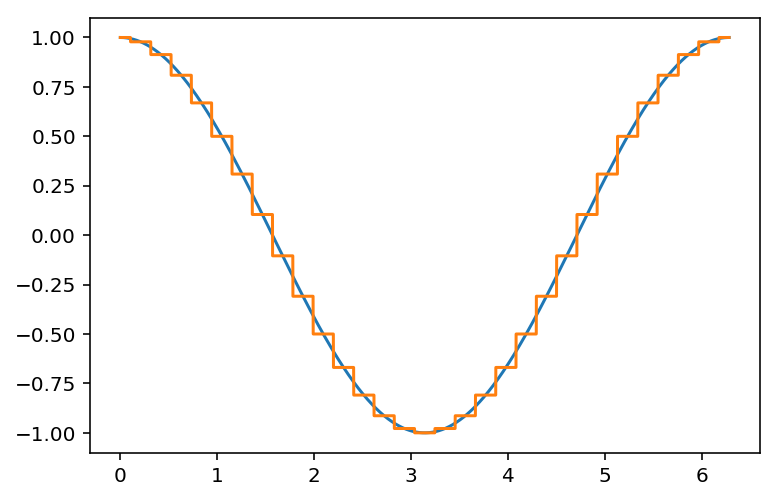

In [55]:
levels = 16
plt.plot(x, y)
# plt.plot(x, pack_angle(y, levels))
plt.plot(x, unpack_angle(pack_angle(y, levels), levels))
plt.show()

In [ ]:
# this might be a reasonable enough representation to learn a vae on this first
# or is it too sparse?
# one really important thing is to make sure that angles are standardized: only positive rotations

In [79]:
import math

_AXES2TUPLE = {
    'sxyz': (0, 0, 0, 0), 'sxyx': (0, 0, 1, 0), 'sxzy': (0, 1, 0, 0),
    'sxzx': (0, 1, 1, 0), 'syzx': (1, 0, 0, 0), 'syzy': (1, 0, 1, 0),
    'syxz': (1, 1, 0, 0), 'syxy': (1, 1, 1, 0), 'szxy': (2, 0, 0, 0),
    'szxz': (2, 0, 1, 0), 'szyx': (2, 1, 0, 0), 'szyz': (2, 1, 1, 0),
    'rzyx': (0, 0, 0, 1), 'rxyx': (0, 0, 1, 1), 'ryzx': (0, 1, 0, 1),
    'rxzx': (0, 1, 1, 1), 'rxzy': (1, 0, 0, 1), 'ryzy': (1, 0, 1, 1),
    'rzxy': (1, 1, 0, 1), 'ryxy': (1, 1, 1, 1), 'ryxz': (2, 0, 0, 1),
    'rzxz': (2, 0, 1, 1), 'rxyz': (2, 1, 0, 1), 'rzyz': (2, 1, 1, 1)}

_TUPLE2AXES = dict((v, k) for k, v in _AXES2TUPLE.items())

# axis sequences for Euler angles
_NEXT_AXIS = [1, 2, 0, 1]

# epsilon for testing whether a number is close to zero
_EPS = np.finfo(float).eps * 4.0

def quaternion_from_euler(ai, aj, ak, axes='sxyz'):
    """Return quaternion from Euler angles and axis sequence.

    ai, aj, ak : Euler's roll, pitch and yaw angles
    axes : One of 24 axis sequences as string or encoded tuple

    >>> q = quaternion_from_euler(1, 2, 3, 'ryxz')
    >>> np.allclose(q, [0.435953, 0.310622, -0.718287, 0.444435])
    True

    """
    try:
        firstaxis, parity, repetition, frame = _AXES2TUPLE[axes.lower()]
    except (AttributeError, KeyError):
        _TUPLE2AXES[axes]  # validation
        firstaxis, parity, repetition, frame = axes

    i = firstaxis + 1
    j = _NEXT_AXIS[i+parity-1] + 1
    k = _NEXT_AXIS[i-parity] + 1

    if frame:
        ai, ak = ak, ai
    if parity:
        aj = -aj

    ai /= 2.0
    aj /= 2.0
    ak /= 2.0
    ci = math.cos(ai)
    si = math.sin(ai)
    cj = math.cos(aj)
    sj = math.sin(aj)
    ck = math.cos(ak)
    sk = math.sin(ak)
    cc = ci*ck
    cs = ci*sk
    sc = si*ck
    ss = si*sk

    q = np.empty((4, ))
    if repetition:
        q[0] = cj*(cc - ss)
        q[i] = cj*(cs + sc)
        q[j] = sj*(cc + ss)
        q[k] = sj*(cs - sc)
    else:
        q[0] = cj*cc + sj*ss
        q[i] = cj*sc - sj*cs
        q[j] = cj*ss + sj*cc
        q[k] = cj*cs - sj*sc
    if parity:
        q[j] *= -1.0

    return q

def euler_from_matrix(matrix, axes='sxyz'):
    """Return Euler angles from rotation matrix for specified axis sequence.

    axes : One of 24 axis sequences as string or encoded tuple

    Note that many Euler angle triplets can describe one matrix.

    >>> R0 = euler_matrix(1, 2, 3, 'syxz')
    >>> al, be, ga = euler_from_matrix(R0, 'syxz')
    >>> R1 = euler_matrix(al, be, ga, 'syxz')
    >>> np.allclose(R0, R1)
    True
    >>> angles = (4*math.pi) * (np.random.random(3) - 0.5)
    >>> for axes in _AXES2TUPLE.keys():
    ...    R0 = euler_matrix(axes=axes, *angles)
    ...    R1 = euler_matrix(axes=axes, *euler_from_matrix(R0, axes))
    ...    if not np.allclose(R0, R1): print(axes, "failed")

    """
    try:
        firstaxis, parity, repetition, frame = _AXES2TUPLE[axes.lower()]
    except (AttributeError, KeyError):
        _TUPLE2AXES[axes]  # validation
        firstaxis, parity, repetition, frame = axes

    i = firstaxis
    j = _NEXT_AXIS[i+parity]
    k = _NEXT_AXIS[i-parity+1]

    M = np.array(matrix, dtype=np.float64, copy=False)[:3, :3]
    if repetition:
        sy = math.sqrt(M[i, j]*M[i, j] + M[i, k]*M[i, k])
        if sy > _EPS:
            ax = math.atan2( M[i, j],  M[i, k])
            ay = math.atan2( sy,       M[i, i])
            az = math.atan2( M[j, i], -M[k, i])
        else:
            ax = math.atan2(-M[j, k],  M[j, j])
            ay = math.atan2( sy,       M[i, i])
            az = 0.0
    else:
        cy = math.sqrt(M[i, i]*M[i, i] + M[j, i]*M[j, i])
        if cy > _EPS:
            ax = math.atan2( M[k, j],  M[k, k])
            ay = math.atan2(-M[k, i],  cy)
            az = math.atan2( M[j, i],  M[i, i])
        else:
            ax = math.atan2(-M[j, k],  M[j, j])
            ay = math.atan2(-M[k, i],  cy)
            az = 0.0

    if parity:
        ax, ay, az = -ax, -ay, -az
    if frame:
        ax, az = az, ax
    return ax, ay, az

def quaternion_matrix(quaternion):
    """Return homogeneous rotation matrix from quaternion.

    >>> M = quaternion_matrix([0.99810947, 0.06146124, 0, 0])
    >>> np.allclose(M, rotation_matrix(0.123, [1, 0, 0]))
    True
    >>> M = quaternion_matrix([1, 0, 0, 0])
    >>> np.allclose(M, np.identity(4))
    True
    >>> M = quaternion_matrix([0, 1, 0, 0])
    >>> np.allclose(M, np.diag([1, -1, -1, 1]))
    True

    """
    q = np.array(quaternion, dtype=np.float64, copy=True)
    n = np.dot(q, q)
    if n < _EPS:
        return np.identity(4)
    q *= math.sqrt(2.0 / n)
    q = np.outer(q, q)
    return np.array([
        [1.0-q[2, 2]-q[3, 3],     q[1, 2]-q[3, 0],     q[1, 3]+q[2, 0], 0.0],
        [    q[1, 2]+q[3, 0], 1.0-q[1, 1]-q[3, 3],     q[2, 3]-q[1, 0], 0.0],
        [    q[1, 3]-q[2, 0],     q[2, 3]+q[1, 0], 1.0-q[1, 1]-q[2, 2], 0.0],
        [                0.0,                 0.0,                 0.0, 1.0]])

def euler_from_quaternion(quaternion, axes='sxyz'):
    """Return Euler angles from quaternion for specified axis sequence.

    >>> angles = euler_from_quaternion([0.99810947, 0.06146124, 0, 0])
    >>> np.allclose(angles, [0.123, 0, 0])
    True

    """
    return euler_from_matrix(quaternion_matrix(quaternion), axes)

In [104]:
q = quaternion_from_euler(-2, 1, 0)
q

array([ 0.47415988, -0.73846026,  0.25903472,  0.40342268])

In [105]:
np.linalg.norm(q)

1.0

In [106]:
euler_from_quaternion(quaternion_from_euler(*euler_from_quaternion(q)))

(-2.000000000000001, 1.0000000000000004, -1.0274091120537493e-16)

In [107]:
# https://www.lfd.uci.edu/~gohlke/code/transformations.py.html

In [108]:
quaternion_matrix(q)

array([[ 0.54030231, -0.7651474 , -0.35017549,  0.        ],
       [ 0.        , -0.41614684,  0.90929743,  0.        ],
       [-0.84147098, -0.4912955 , -0.2248451 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])